<a href="https://colab.research.google.com/github/ebatty/ComputationalBootcamp/blob/master/content/TuningCurvesTutorial.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>

# Visualizing Neural Responses & Building Tuning Curves



In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
import matplotlib.pyplot as plt
import ipywidgets as widgets 

## Section 1: Experimental set-up

<details>
<summary> <font color='blue'>Click here for recap of experimental set-up that we went through together </font></summary>

You have a hypothesis that some neurons in monkey motor cortex correlate with the direction of arm movement while reaching. By this, you mean that a particular neuron will fire more when the monkey reaches in certain directions than others.  


You choose an experimental set-up which will allow pretty easy analysis of the data. You have a monkey reach in eight different directions while recording from the neuron. Importantly, you have the monkey reach in each direction numerous times, not just once. You record the time the reach is initiated, perhaps by having the monkey hold onto a joystick with a sensor in it until they reach (the sensor can automatically record when the monkey lets go).

This is a typical experimental protocol in neuroscience: recording the spike times of a neuron while presenting the same stimulus over and over, or having the animal perform the same behavior over and over. Each presentation of the stimulus or iteration of the behavior is called a **trial**. 

You go ahead and perform your experiment and collect a bunch of data. You now have the spike times of the neuron during multiple reachs in the same direction. You do this for 8 directions defined by angles of 0, 45, 90, 135, 180, 225, 270, 315 

 Click to generate the data


In [2]:
# @markdown Click to generate the data

np.random.seed(123)

# Set up parameters for faking data
n_trials = 10
trial_length = 1500 #ms

angles = np.array([0, 45, 90, 135, 180, 225, 270, 315])
firing_rates = np.array([5, 8, 40, 54, 55, 38, 24, 8])

# Loop over angles & fake data
reach_sp_times = {}
for i_angle in range(8):
    reach_firing_rates = 15*np.ones((1500))
    reach_firing_rates[(750 - 250):(750 + 250)] = firing_rates[i_angle]

    bin_width = 1/1000

    all_sp_time_list = []
    for i_trial in range(n_trials):

        binned_spikes = np.random.poisson(reach_firing_rates * bin_width)
        sp_times = np.where(binned_spikes)[0]
        sp_times = sp_times + np.around(.01*np.random.randn(sp_times.shape[0]), 3)

        all_sp_time_list.append(sp_times)

    reach_sp_times[angles[i_angle]] = all_sp_time_list


Your data is stored in a variable `reach_sp_times`, the angles are in `angles`. We have `n_trials` = 10 (so 10 trials per reach direction, and the length of each trial is 1500 ms. The data is aligned so the target was reach at 750 ms in each trial. You can access the data for each of the 8 angles by indexing in with `reach_sp_times[angle]`. So for example, you can get the data for reaches to the angle of 45 degrees with `reach_sp_times[45]`. 

The data for each angle is stored as a list of arrays, where each array has the spike times for a single trial

In [3]:
print(n_trials)
print(trial_length)
print(angles)

10
1500
[  0  45  90 135 180 225 270 315]


In [4]:
reach_sp_times[180]

[array([ 107.99 ,  126.998,  257.988,  324.007,  337.   ,  468.007,
         527.007,  535.001,  550.001,  557.005,  576.997,  578.984,
         592.004,  593.993,  598.989,  624.01 ,  628.005,  642.002,
         646.013,  654.006,  674.999,  704.004,  707.01 ,  708.992,
         750.999,  798.992,  810.987,  821.013,  841.005,  850.998,
         879.994,  885.011,  905.007,  907.994,  935.993,  964.995,
        1021.016, 1030.022, 1061.002, 1186.997, 1207.004, 1336.973,
        1346.99 , 1357.999, 1402.011, 1426.999]),
 array([ 116.99 ,  256.016,  258.009,  264.988,  363.003,  500.001,
         507.988,  509.011,  524.001,  526.995,  543.993,  556.997,
         575.977,  613.002,  638.012,  647.012,  654.014,  656.997,
         658.999,  661.996,  682.99 ,  704.993,  718.998,  734.998,
         740.009,  741.983,  752.01 ,  764.003,  765.999,  783.   ,
         805.987,  807.005,  822.978,  866.001,  873.995,  899.007,
         906.983,  912.985,  916.994,  924.986,  930.006,  932.981

We can get the spike times of a single trial by indexing with `reach_sp_times[angle][trial number]`

In [5]:
reach_sp_times[180][2]

array([  17.002,   76.995,   83.01 ,  150.992,  183.982,  226.999,
        234.99 ,  388.997,  552.015,  563.995,  639.994,  688.002,
        689.007,  696.006,  714.999,  719.012,  734.996,  745.001,
        766.   ,  793.979,  852.995,  886.997,  905.99 ,  917.99 ,
        928.009,  945.98 ,  956.   ,  968.002,  974.007,  978.01 ,
        983.012,  990.012,  992.997, 1025.012, 1185.997, 1225.999,
       1251.01 , 1292.992, 1301.009, 1333.017, 1368.994, 1388.999,
       1411.993, 1425.032])

**Stop and think!** What should you do next?


 Click to see


In [6]:
# @markdown Click to see

"""
Always visualize your data before analyzing it!
""";

## Section 2: Raster plots





<details>
<summary> <font color='blue'>Click here for recap of raster plot </font></summary>

An excellent and common way to visualize neural spiking in multiple trials is a **raster plot**, an example of which can be found in Figure 1. In this style of plot, time is represented on the x-axis. Each spike is represented by a vertical line at the time it occurs. Each row (y-axis) can be a separate trial - in this case the raster plot displays a single neuron's responses over multiple trials and can be used to quickly assess response variability. Note that the timing of each trial needs to be synced. In other words, the stimulus onset, or event onset, should happen at the same time in each trial. 

<img src="https://github.com/ebatty/EncodingDecodingNotes/blob/main/images/Putnametal.png?raw=True"  width="600">


*Figure 1: An example raster plot, adapted from [Putnam and Gothard, eNeuro 2019](https://www.eneuro.org/content/6/5/ENEURO.0153-19.2019), under [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)*

The raster in Figure 1, adapted from [Putnam and Gothard, eNeuro 2019](https://www.eneuro.org/content/6/5/ENEURO.0153-19.2019), shows neural data from monkey amygdala, recorded while the monkey repeatedly watches a video. The red lines indicate the onset and offset of the video.


**Plotting rasters in Python**

We can create raster plots in matplotlib by using [`plt.eventplot`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.eventplot.html). 

The input to this plotting function should be a list of arrays, where each array contains the spike times for a different trial. This is how our data is already formatted so that makes it easier for us to plot.

**Coding challenge**: Fill out the code below to plot the raster for one reach direction. Add a x-axis label and a y-axis label

The blue vertical line indicates when the monkey reached the target. 

Once you have it working, look at rasters for a few reach directions - what directions does this neuron seem to respond to?

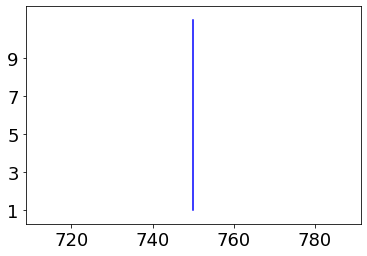

In [7]:
fig, ax = plt.subplots(1, 1)

### TODO: call ax.eventplot with the data for one of the reach directions
# your code here

# Indicate when target was reached
ax.plot([750, 750], [0, 10], 'b')

# Set info on the plot
ax.set(
  ylim = [-.7, 10.7],
  yticks = np.arange(0, 10, 2),
  yticklabels = np.arange(1, 11, 2));


 Click here for solution


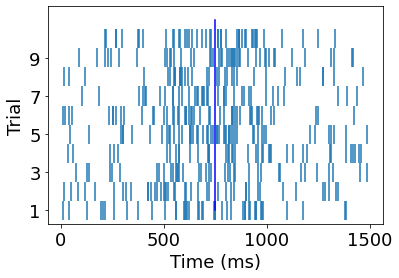

In [8]:
# @markdown Click here for solution
fig, ax = plt.subplots(1, 1)

### TODO: call ax.eventplot with the data for one of the reach directions
angle = 135
ax.eventplot(reach_sp_times[angle])

# Indicate when target was reached
ax.plot([750, 750], [0, 10], 'b')

# Set info on the plot
ax.set(
  ylim = [-.7, 10.7],
  yticks = np.arange(0, 10, 2),
  yticklabels = np.arange(1, 11, 2),
  xlabel = 'Time (ms)',
  ylabel = 'Trial');

## Section 3: PSTHs

We can summarize the information over trials contained in a raster plot in a peri-stimulus time histogram (PSTH), also sometimes called a peri-event time histogram (PETH). In a PSTH, we want to show the average underlying firing rate over time. 

To do that, we need to use discrete chunks of time - we divide time into time bins of some length. 


For each time bin, we can then count the number of spikes in that time bin over all the trials. We can then get the average spikes/bin for that time bin during the trial as the the number of spikes divided by the number of trials. We can convert to spikes/second by dividing by the bin length in seconds.




### Section 3.1: Binning the spikes

**Advanced Challenge:** Given a single trial of spike times, can you figure out how to use `np.histogram` to bin the spikes into 10 ms bins? 


In [9]:
bin_length = 10

# Get one trial of data
sp_times = reach_sp_times[45][0]

# TODO: get the spike counts in 10 ms bins
# your code here

 Click to see solution


In [10]:
# @markdown Click to see solution

bin_length = 10

# Get one trial of data
sp_times = reach_sp_times[45][0]

# Get the spike counts in 10 ms bins
binned_spikes, _ = np.histogram(sp_times, bins=np.arange(0, trial_length+1, bin_length))

For a certain direction (let's start with angle 315), we want to change our data format. Instead of specific spike times, we want an array where the number of rows is the number of trials and each column is a single 10 ms time bin. The entries should be the spike counts.

**Really Advanced Challenge (uses things we haven't covered yet)**: Do this on your own if you are already experienced in Python. Otherwise run the next cell (no need to understand all the details of the code - you shouldn't be able to yet!)

 Click to see solution


In [11]:
# @markdown Click to see solution

# I'm going to do it for all the angles at once

n_bins = int(trial_length/bin_length)

# Loop over angles 
binned_spikes = {}
for i_angle in range(8):

    # Set up array for storing data
    these_binned_spikes = np.zeros((n_trials, n_bins))

    # Loop over trials
    for i_trial in range(n_trials):
        these_binned_spikes[i_trial], _ = np.histogram(reach_sp_times[angles[i_angle]][i_trial], bins=np.arange(0, trial_length+1, bin_length))

    binned_spikes[angles[i_angle]] = these_binned_spikes

You now have a variabled `binned_spikes`. You can access the data for a specific reach angle the same way as before, with `binned_spikes[angle]`. 

**Coding challenge**: Check out the array stored for the angle 180. How many rows and columns should there be? Are there the correct number? What is the maximum and minimum entry in the array? Do those numbers make sense given the data being stored?

In [12]:
binned_spikes[180]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Section 3.2: Computing the PSTH

Now we have our data in a cleaner and more usable format! 

**Coding challenge**: Compute the PSTH! You want the average firing rate over time in spikes per second for a reach to an angle of 180 degrees. Think about how you would go from the binned spike counts for each trial to an average firing rate

In [13]:
# TODO: compute the PSTH
# your code here

 Click here for the solution


In [14]:
# @markdown Click here for the solution

bin_length_in_seconds = bin_length/1000

PSTH = np.mean(binned_spikes[180], axis=0)/bin_length_in_seconds
PSTH

array([  0.,  20.,   0.,  20.,  20.,  10.,  10.,  20.,  30.,  10.,  30.,
        30.,  20.,  20.,  10.,  20.,  10.,   0.,  10.,   0.,  20.,   0.,
        30.,  20.,  10.,  50.,  20.,  10.,  10.,   0.,  30.,  30.,  10.,
        10.,  30.,  10.,  10.,  20.,  10.,  30.,  10.,  10.,   0.,   0.,
        20.,   0.,  30.,  10.,  10.,   0.,  30.,  20.,  70.,  50.,  20.,
        80.,  50.,  90.,  30., 120.,  70.,  80.,  40.,  60., 110.,  90.,
        30.,  50., 110.,  50.,  80.,  90.,  70.,  80.,  70.,  70.,  60.,
        60.,  40., 100.,  40.,  30.,  50.,  60.,  50., 100.,  50.,  30.,
        60.,  40.,  90.,  40.,  90.,  80.,  70.,  20.,  30.,  70.,  60.,
        60.,  10.,  30.,  30.,  50.,  10.,  20.,  10.,  20.,  10.,  20.,
        20.,  30.,  10.,   0.,  10.,   0.,  20.,  30.,  20.,  30.,  20.,
         0.,  20.,  10.,   0.,  20.,  10.,   0.,  10.,  10.,  10.,  10.,
        10.,  40.,  30.,  20.,  10.,  10.,  10.,  30.,  10.,  20.,  40.,
        10.,  10.,  30.,  10.,  10.,   0.,  10.])

**Coding challenge**: plot the average firing rate over time for a reach to an angle of 180 degrees. 

In [15]:
# TODO: plot the PSTH
# your code here

 Click here for the solution


[Text(0, 0.5, 'Firing rate (spikes/second)'), Text(0.5, 0, 'Time (ms)')]

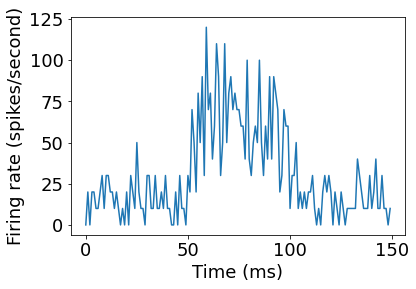

In [16]:
# @markdown Click here for the solution

fig, ax = plt.subplots(1, 1)
ax.plot(PSTH)
ax.set(xlabel = 'Time (ms)',
       ylabel = 'Firing rate (spikes/second)')

**Stop and think!** To compute the PSTH, we binned the spikes into 10 ms bins. What would happen if you choose a bin length that's too big? Too small? Think about it, then play with the demo below to see if your intuitions are correct. In the demo, the red lines indicate the edges of the bins


 Execute to enable demo


In [17]:
# @markdown Execute to enable demo
def plot_raster_and_PSTH(all_sp_time_list, bin_edge_times, PSTH):
  fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

  # Make raster of this data
  axes[0].eventplot(all_sp_time_list, colors = 'black')
  axes[0].set(ylabel = 'Trial Number',
        xlim = [0, trial_length],
        ylim = [-.7, 4.7],
        yticks = [0, 1, 2, 3, 4],
        yticklabels = [1, 2, 3, 4, 5]);

  # Plot bin vertical lines 
  for bin_time in bin_edge_times:
    axes[0].plot([bin_time, bin_time], [-.7, 4.7], 'r')

  # Plot PSTH
  x_vals = np.arange(0, trial_length, .1)
  y_vals = np.zeros((len(x_vals)))
  for i_bin in range(len(bin_edge_times) - 1):
    y_vals[(x_vals > bin_edge_times[i_bin]) & (x_vals <= bin_edge_times[i_bin + 1])] = PSTH[i_bin] 

  axes[1].plot(x_vals, y_vals,  'k');
  axes[1].set(xlabel = 'Time (ms)', 
              ylabel = 'Firing rate (spikes/second)');


@widgets.interact(bin_length = widgets.IntSlider(value=10, min=1, max=200, step=1,  description='Bin length'))
def plot_PSTH(bin_length):
    
    # Set up array for storing data
    n_bins = int(trial_length/bin_length)
    these_binned_spikes = np.zeros((n_trials, n_bins))
    bin_edge_times = np.arange(0, trial_length+1, bin_length)
    
    # Loop over trials
    for i_trial in range(n_trials):
        these_binned_spikes[i_trial], _ = np.histogram(reach_sp_times[180][i_trial], bins=np.arange(0, trial_length+1, bin_length))

    PSTH = np.mean(these_binned_spikes, axis=0)/bin_length_in_seconds

    # Visualize
    plot_raster_and_PSTH(reach_sp_times[180], bin_edge_times, PSTH)

interactive(children=(IntSlider(value=10, description='Bin length', max=200, min=1), Output()), _dom_classes=(…

 Click to see answer


In [18]:
# @markdown Click to see answer

"""
Too big a bin and you might lose temporal information in the neural reponses because 
you're summing spikes over a long period of time. Too small a bin and the PSTH could 
be hard to interpret. For example, imagine if you chose a time bin small enough 
that there was almost always at most 1 spike in each, even across all trials. 
The PSTH would not convey much information. 
""";

## Section 4: Tuning curves

These raster plots and PSTHs are very informative but we want a more succint summary of how the neuron responds to different reach directions. We can get this by creating and plotting a tuning curve. Specifically, to construct a tuning curve, we plot the average firing rate of the neuron for each reach direction vs the reach direction

**Stop and think!** How could we get the average firing rate of the neuron for a certain reach?

 Click to see answer


In [19]:
# @markdown Click to see answer

"""
First, we choose some time window around the time the target is reached (750 ms in these trials).
 We then count up the spikes over all trials in that time window and divide by both the number of trials and 
the length of the time window to get firing rate in terms of spikes per second. 
""";



For this data, we will choose a 500 ms time window: 250 ms before reach onset and 250 ms after.

**Coding challenge:** Get a single firing rate for a reach to 180 degrees using the 500 ms time window. 

Hint: use `binned_spikes` for this, no need to go back to the spike times

Hint2: some functions or indexing calls require integers (whole numbers). They could return an error if you try to use 50.0 for example instead of 50. To convert a decimal point number to an integer you can use `int`. For example `int(50.0)`

In [20]:
# your code here

 Click here for solution


In [21]:
# @markdown Click here for solution

# We want to look at 500 to 1000 ms in the trial. We need to 
# index into the binned spikes array, so we need to figure out what 
# bin number correponds to this time. Dividing 500 ms by the bin
# length of 10 ms gives us 50. Bin 50 is the first one we want to grab then.
# We use int() to convert this number to an integer, otherwise we'll get
# an error if we try to index with it
start_bin = int(500/bin_length)
end_bin = int(1000/bin_length)
total_time = .5 # seconds

np.sum(binned_spikes[180][:, start_bin:end_bin])/n_trials/total_time;

**Coding challenge:** Compute this firing rate for each of the angles (0, 45, 90, 135, 180, 225, 270, 315). Store each in the array `av_firing_rate`. So the first entry in that array should be the firing rate for reaches to 0 degrees, the second reaches to 90 degrees, and so on.

In [22]:
av_firing_rate = np.zeros((8, ))

# your code here

 Click here for the solution


In [23]:
# @markdown Click here for the solution
av_firing_rate = np.zeros((8, ))

av_firing_rate[0] = np.sum(binned_spikes[0][:, start_bin:end_bin])/n_trials/total_time
av_firing_rate[1] = np.sum(binned_spikes[45][:, start_bin:end_bin])/n_trials/total_time
av_firing_rate[2] = np.sum(binned_spikes[90][:, start_bin:end_bin])/n_trials/total_time
av_firing_rate[3] = np.sum(binned_spikes[135][:, start_bin:end_bin])/n_trials/total_time
av_firing_rate[4] = np.sum(binned_spikes[180][:, start_bin:end_bin])/n_trials/total_time
av_firing_rate[5] = np.sum(binned_spikes[225][:, start_bin:end_bin])/n_trials/total_time
av_firing_rate[6] = np.sum(binned_spikes[270][:, start_bin:end_bin])/n_trials/total_time
av_firing_rate[7] = np.sum(binned_spikes[315][:, start_bin:end_bin])/n_trials/total_time


**Coding challenge:** Plot the average firing rate at each angle

In [24]:
# your code here

 Click here for the solution


[Text(0, 0.5, 'Average firing rate (spikes/second)'),
 Text(0.5, 0, 'Reach direction (degrees)')]

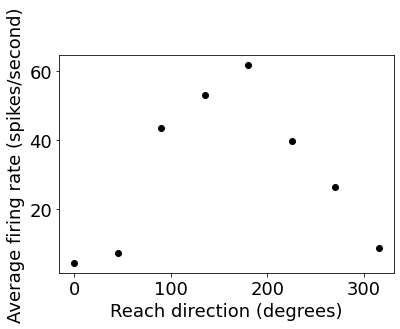

In [25]:
# @markdown Click here for the solution

fig, ax = plt.subplots(1, 1)
ax.plot(angles, av_firing_rate, 'ok')
ax.set(xlabel = 'Reach direction (degrees)',
       ylabel = 'Average firing rate (spikes/second)')

This plot of firing rate vs reach direction quickly helps us see the "tuning" of the neuron, or how it's response varies across reach directions. This neuron is responding the most to degrees around 180, with smaller responses to higher and lower angles of reach. 

## Section 5: Parameterizing the tuning curve

This plot of firing rate vs reach direction quickly helps us see the "tuning" of the neuron, or how it's response varies across reach directions. This neuron is responding the most to degrees around 180, with smaller responses to higher and lower angles of reach. 

We can summarize this information even more efficiently by doing some curve fitting. It turns out that the tuning of motor cortex neurons can be described well with a cosine curve. In particular, we can model the firing rate for each angle as:

$$f(a) = [r_0 + (r_{max} - r_0) cos(a - a_{max})]_+$$

$a$: reaching angle

$a_{max}$: reaching angle associated with highest response

$r_{max}$: maximum response

$r_0$: offset or background firing rate

$[x]_+$ means the quantity is half-wave rectified (negative values are set to 0, since we can't have negative firing rates

We fit this equation for a particular neuron by finding the values of $a_{max}$, $r_{max}$, and $r_0$ that match this curve closely to the data points. We can then quickly summarize the tuning of each neuron with these fitted parameters.


**Coding challenge**: Let's first guess at some good values for $r_0$, $r_max$, and $a_max$. Create an array, `f`, that has the output of the above equation for every angle between 0 and 360. So f should be an array with 360 entries.

*Hint:* `np.cos` computes the cosine given an angle input. The angle needs to be in radians not degrees though. You can convert using `np.deg2rad`

In [29]:
# Guesses at parameters
r_0 = 10
r_max = 60
a_max =  180

# Make an array with all angles between 0 and 360
all_angles = np.arange(0, 360, 1)

# TODO: Compute f
# your code here

 Click here for solution


In [47]:
# @markdown Click here for solution

# Guesses at parameters
r_0 = 20
r_max = 60
a_max =  180

# Make an array with all angles between 0 and 360
all_angles = np.arange(0, 360, 1)

# TODO: Compute f
f = r_0 + (r_max - r_0)*np.cos(np.deg2rad(all_angles) - np.deg2rad(a_max))

# Set negative elements of f to 0
f[f<0] = 0

I'll now plot this curve overlaid on the real data

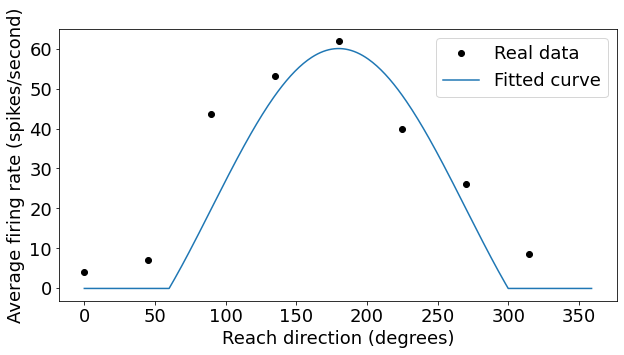

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(angles, av_firing_rate, 'ok', label = 'Real data')
ax.plot(all_angles, f, label = 'Fitted curve')
ax.set(xlabel = 'Reach direction (degrees)',
       ylabel = 'Average firing rate (spikes/second)')
ax.legend()

Our guesses for $r_0$, $r_max$, and $a_max$ got the curve pretty close to the data but I think we can do better. We can fit the curve (model) to the data by automatically finding the parameters that minimize some quantity. We'll get into this next week!

**Stop and think:** What quantity might you want to minimize to get the curve to closely mimic the data?